In [185]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [186]:
df = pd.read_csv("dataset/user_chat.csv")
df2 = pd.read_csv("dataset/products.csv")

In [187]:
PRODUCT_KEYWORDS = [
    "produk", "barang", "item",
    "harga", "diskon", "promo",
    "stok", "ready", "tersedia",
    "garansi", "original", "ori",
    "pengiriman", "kirim", "delivery",
    "cod", "bayar",
    "warna", "ukuran",
    "rating", "review",
    "kualitas"
]

BOT_PRODUCT_KEYWORDS = [
    "produk", "harga", "stok", "promo",
    "garansi", "pengiriman", "tersedia",
    "diskon", "kualitas", "original"
]


In [188]:
def extract_product_tokens(series):
    tokens = set()

    for text in series.dropna():
        words = re.findall(r"[a-zA-Z]{3,}", text.lower())
        tokens.update(words)

    return tokens

PRODUCT_TOKENS = (
    extract_product_tokens(df2["name"]) |
    extract_product_tokens(df2["description"])
)

In [189]:
def check_chat_product(chat, product_tokens):
    if not isinstance(chat, str):
        return 1

    chat = chat.lower().strip()

    # kosong atau terlalu pendek
    if len(chat) < 3:
        return 1

    # cek apakah ada kata kunci produk
    for kw in df2['name']:
        if kw in chat:
            return 0
    for kw in df2['description']:
        if kw in chat:
            return 0
    # cek apakah ada kata kunci produk
    for kw in PRODUCT_KEYWORDS:
        if kw in chat:
            return 0

    words = set(re.findall(r"[a-zA-Z]{3,}", chat.lower()))
    return 0 if words & product_tokens else 1

def check_bot_response_product(response, product_tokens):
    if not isinstance(response, str):
        return 1

    response = response.lower().strip()

    if len(response) < 5:
        return 1

    for kw in BOT_PRODUCT_KEYWORDS:
        if kw in response:
            return 0
    # cek apakah ada kata kunci produk
    for kw in df2['name']:
        if kw in response:
            return 0
    for kw in df2['description']:
        if kw in response:
            return 0

    words = set(re.findall(r"[a-zA-Z]{3,}", response.lower()))
    return 0 if words & product_tokens else 1

In [190]:
# Chat
df["bot_chat"] = df["chat"].apply(
    lambda x: "valid" if check_chat_product(x, PRODUCT_TOKENS) == 0 else "unknown"
)

# Bot Response
df["bot_response"] = df["bot_response"].apply(
    lambda x: "valid" if check_bot_response_product(x, PRODUCT_TOKENS) == 0 else "unknown"
)


In [191]:
# Ubah valid/unknown menjadi 0/1
df["bot_chat"] = df["bot_chat"].map({"valid": 0, "unknown": 1})
df["bot_response"] = df["bot_response"].map({"valid": 0, "unknown": 1})

# Hitung skor
df["bot_score"] = df["bot_chat"] + df["bot_response"]

# Label akhir
df["label"] = df["bot_score"].apply(lambda x: "invalid" if x > 0 else "valid")


In [192]:
print("\nLabel distribution BEFORE:")
print(df["label"].value_counts())


Label distribution BEFORE:
label
valid      659
invalid    343
Name: count, dtype: int64


In [193]:
df["text"] = (
    df["bot_chat"].astype(str) + " " +
    df["bot_response"].astype(str) + " "
).str.lower().str.strip()

In [194]:
vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(2,5),
    max_features=800
)
X = vectorizer.fit_transform(df["text"])
y = df["label"]

In [195]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [196]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [197]:
y_pred = model.predict(X_test)

In [198]:
print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

     invalid       1.00      1.00      1.00       103
       valid       1.00      1.00      1.00       198

    accuracy                           1.00       301
   macro avg       1.00      1.00      1.00       301
weighted avg       1.00      1.00      1.00       301

Confusion Matrix:

[[103   0]
 [  0 198]]


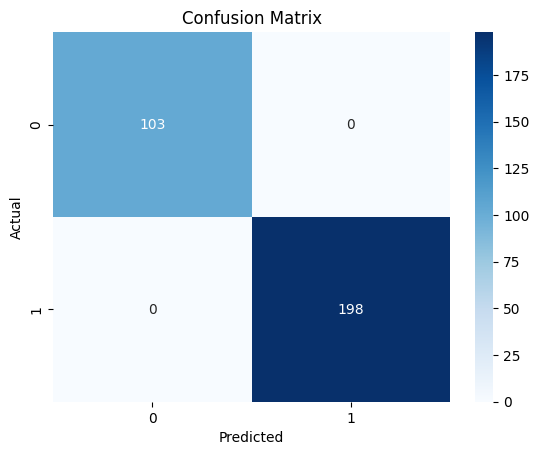

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [202]:
def accuracy_chatbot():
    return round(accuracy_score(y_test, y_pred), 4)